In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import animation as am

In [41]:
L = 255
h = 0.4
p = 0.34
q = 0.33

label = 'L_'+str(L)+'_h_'+str(h)+'_p_'+str(p)+'_q_'+str(q)
file = open("data_{}.txt".format(label))

realisations = []
flag = True 
n_realisations = 100 

n = 0 

while n < n_realisations: 
    line = file.readline() 
    if line[0] == '#':
        flag = True 
        print(line)
    else: 
        if flag:  
            new_realisation = [line]
            realisations.append(new_realisation)
            n += 1 
            flag = False
        else:
            new_realisation.append(line)
            
realisations = realisations[:-1]

#Parameters={ Seed: 5, Branching rate: 0.4, p : 0.34, q : 0.33, Realisations: 100, Chunk size: 100, Dimension: 2, (Max) Lattice size: 255, Graph Type: 0 }

#Version: #464f

# Running for L = 255

# Starting the 0 th realisation 

# Starting the 1 th realisation 

# Starting the 2 th realisation 

# Starting the 3 th realisation 

# Starting the 4 th realisation 

# Starting the 5 th realisation 

# Starting the 6 th realisation 

# Starting the 7 th realisation 

# Starting the 8 th realisation 

# Starting the 9 th realisation 

# Starting the 10 th realisation 

# Starting the 11 th realisation 

# Starting the 12 th realisation 

# Starting the 13 th realisation 

# Starting the 14 th realisation 

# Starting the 15 th realisation 

# Starting the 16 th realisation 

# Starting the 17 th realisation 

# Starting the 18 th realisation 

# Starting the 19 th realisation 

# Starting the 20 th realisation 

# Starting the 21 th realisation 

# Starting the 22 th realisation 

# Startin

In [42]:
def extract_lite(realisation): 
    total_active = [] 
    total_tracer = [] 
    tracer_snapshot = np.zeros((L, L)) 
    time = [] 

    for line in realisation:  
        if line.startswith('time'):
            time.append(float(line[5:-1]))
        if line.startswith('total active'):
            total_active.append(float(line[13:-1]))
        if line.startswith('total tracer'):
            total_tracer.append(float(line[13:-1]))
        if line.startswith('passive'):
            passive_indices = np.fromstring(line[8:-1], sep=',')
            passive_indices = np.unravel_index(passive_indices.astype('int'), (L, L))
    tracer_snapshot[passive_indices] = 1 # set occupied sites to -1 
    
    return time, total_active, total_tracer, tracer_snapshot 


def extract_evolution(realisation): 
    tracers = []
    active_particles = [] 
    edges = [] 
    msds = [] 
    total_active = [] 
    total_tracer = [] 
    time = [] 
    passive_flag = False 
    active_flag = False
    for line in realisation:  
        if line.startswith('time'):
            time.append(float(line[5:-1]))
        elif line.startswith('total active'):
            total_active.append(float(line[13:-1]))
        elif line.startswith('total tracer'):
            total_tracer.append(float(line[13:-1]))
        elif line.startswith('passive'):
            passive_indices = np.fromstring(line[8:-1], sep=',')
            passive_indices = np.unravel_index(passive_indices.astype('int'), (L, L))
            passive_flag = True 
        elif line.startswith('active'):
            active_indices = np.fromstring(line[7:-1], sep=',')
            active_indices = np.unravel_index(active_indices.astype('int'), (L, L))
            active_flag = True 
        elif line.startswith('msd'):
            msds.append(float(line[4:-1]))
        elif line.startswith('edge'): 
            edges.append(np.fromstring(line[5:-1], sep=','))
        else: 
            tracer_snapshot = np.zeros((L, L)) # clear the snapshot for the next time slice 
            active_snapshot = np.zeros((L, L)) 
            
        if passive_flag and active_flag: 
            tracer_snapshot[passive_indices] = 1 # set occupied sites to -1 
            
            for (i,j) in zip(*active_indices):
                active_snapshot[i, j] += 1 
            tracers.append(tracer_snapshot)
            active_particles.append(active_snapshot)
            passive_flag = False 
            active_flag = False 
            
    return np.array(edges), np.array(msds), np.array(counts), np.array(tracers), np.array(active_particles)

def make_movies(evolution, label):
    fig = plt.figure(figsize=(20, 20))
    ims = []
    plt.axis('off')
    for xy in evolution:
        im = plt.imshow(xy, animated=True, vmin=0, vmax=2, cmap='Blues', origin='lower') 
        plt.axis('off')
        ims.append([im])
        
    ani = am.ArtistAnimation(fig, ims, interval=100, blit=True,
                                    repeat_delay=1000)
    mywriter = am.FFMpegWriter()
    ani.save("{}_movie_{}.mp4".format(label, i), writer=mywriter)
    plt.close()  
    
    
def pad(nested_lists): 
    max_length = max(map(len, nested_lists))
    for l in nested_lists: 
        length = len(l)
        if length < max_length: 
            l.extend([l[-1]]*(max_length-length))
    return np.vstack(nested_lists)

def select_longest(times): 
    return max(times, key=lambda x:len(x))
    
    

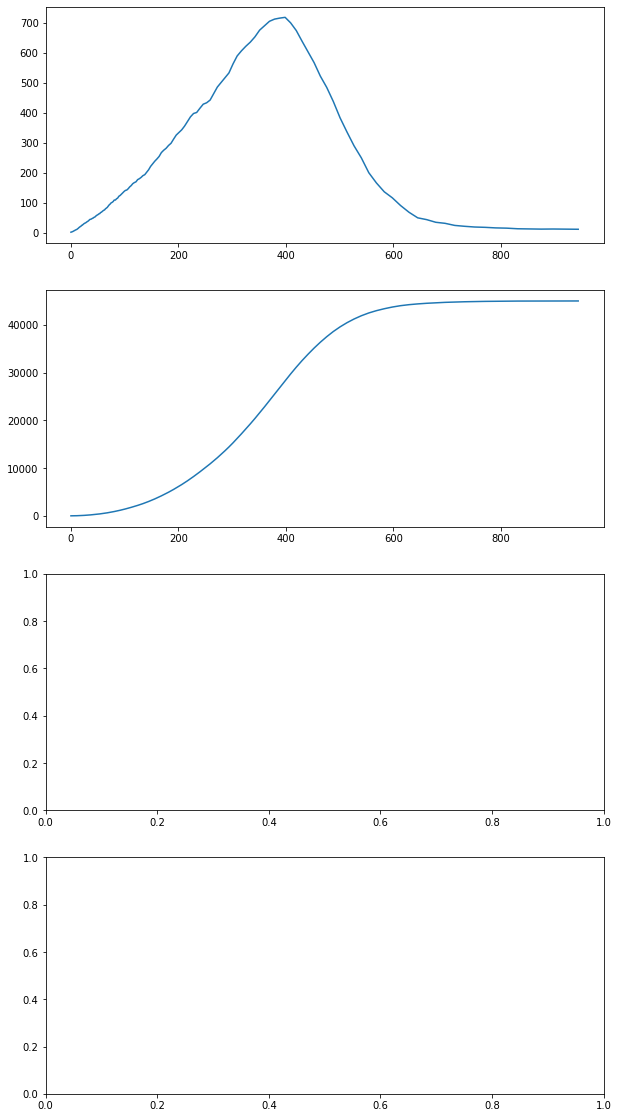

In [43]:
actives = [] 
tracers = [] 
tracer_snapshots = [] 
times = [] 

for (i, realisation) in enumerate(realisations):
    time, total_active, total_tracer, tracer_snapshot = extract_lite(realisation)
    times.append(time)
    actives.append(total_active)
    tracers.append(total_tracer)
    tracer_snapshots.append(tracer_snapshot)
    
t_array = select_longest(times)
actives = pad(actives)
tracers = pad(tracers)

_, axes = plt.subplots(3, figsize=(10, 20))
m1 = np.mean(actives, axis=0)
axes[0].plot(t_array, m1)
m2 = np.mean(actives**2, axis=0)
m4 = np.mean(actives**4, axis=0)
binder = np.divide(m4,3*(m2**2))
axes[1].plot(t_array, binder)
m1 = np.mean(tracers, axis=0)
axes[2].plot(t_array, m1)

# _, axes = plt.subplots(5, figsize=(10, 20))

# for (i, n) in enumerate(range(1, 6)): 
#     m = np.mean(actives**n, axis=0)
#     axes[i].plot(t_array, m)
#     axes[i].set_xscale('log')
    
# _, axes = plt.subplots(5, figsize=(10, 20))
    
# for (i, n) in enumerate(range(1, 6)): 
#     m = np.mean(tracers**n, axis=0)
#     axes[i].plot(t_array, m)
#     axes[i].set_xscale('log')
   